In [22]:
import warnings
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from utils.config import table_translate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
warnings.filterwarnings('ignore')


rs = 132
dataset = pd.read_csv('./data/dataset.csv', dtype={"股票代码": "object"})
others = pd.read_csv('./data/un_unit.csv', dtype={"股票代码": "object"})
others.drop(["Unnamed: 0"], axis=1, inplace=True)
# dataset.set_index('股票简称', inplace=True)
dataset.set_index(['股票代码', "截止日期"], inplace=True)
features = [
    '净资产收益率(%)', '资产报酬率(%)', 'EBITDA率(%)', '营业收入增长率(%)', '成本费用利润率(%)', '总资产周转率(%)', '应收账款周转率(%)', '存货周转率(%)', '营业周期', '现金资产比率(%)', '技术人员占比(%)', '研发营收比(%)', '发明专利申请数', '数字化软硬件投入比(%)', '数字化战略导向前瞻性', '数字化战略导向持续性', '数字化战略导向广度', '数字化战略导向强度', '数字发明专利', '数字国家级奖项', '数字创新论文', '数字创新标准', '数字创新资质', '管理层数字职务设立', '两权分离率(%)', '数字人力计划投入', '数字资本计划投入', '科技创新基地建设', '员工人均营收比(%)', '提供岗位增长率(%)', '员工收入增长率(%)', '社会责任报告质量', '供应链合作伙伴', '数字化供应链覆盖度', '客户集中度(%)', '供应商集中度(%)'
]
label_name = 'score'
# 获取数据集和标签值
y : pd.Series = dataset[label_name]
X : pd.DataFrame = dataset[features].copy(deep=True).astype("float")
# 数据预处理：1.极差标准化；2.数据集划分。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

params = {"iterations": 300, "learning_rate": 0.36, "depth": 2, "l2_leaf_reg": 0.21, 'bagging_temperature': 0.1, "border_count": 49}
model = CatBoostRegressor(random_state=rs, verbose=0, train_dir=None, allow_writing_files=False, **params)
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("最优模型选择为 {0},其各项表现分别为：mse:{1:.2%}  rmse:{2:.2%}  mae:{3:.2%}   r2:{4:.2%}".format("CatBoost", mse,np.sqrt(mse), mae, r2))

最优模型选择为 CatBoost,其各项表现分别为：mse:0.00%  rmse:0.33%  mae:0.15%   r2:98.46%


In [24]:
# 寻找代表企业分析
totals = dataset[features].copy(deep=True).astype("float")
totals = pd.DataFrame(scaler.transform(totals), columns=totals.columns, index=dataset.index)
totals["预测值"] = model.predict(totals)
y.name = "期望值"
totals = pd.merge(totals.reset_index(),y.reset_index(), on=["股票代码","截止日期"], how='outer')
totals = pd.merge(others, totals, on=["股票代码","截止日期"], how='left')
totals = totals[["股票代码", "股票简称", "截止日期", "行业名称", "所属省份", "股权性质","期望值", "预测值"]]
totals

,股票代码,股票简称,截止日期,行业名称,所属省份,股权性质,期望值,预测值
0,000012,南玻A,2018,非金属矿物制品业,广东省,民营,0.045124,0.045052
1,000012,南玻A,2019,非金属矿物制品业,广东省,民营,0.052991,0.053306
2,000012,南玻A,2020,非金属矿物制品业,广东省,民营,0.087072,0.086358
3,000012,南玻A,2021,非金属矿物制品业,广东省,民营,0.098323,0.097051
4,000012,南玻A,2022,非金属矿物制品业,广东省,民营,0.098686,0.100695
...,...,...,...,...,...,...,...,...
8611,900953,凯马B股,2019,汽车制造业,上海市,国企,0.005580,0.006882
8612,900953,凯马B股,2020,汽车制造业,上海市,国企,0.007651,0.007871
8613,900953,凯马B,2021,汽车制造业,上海市,国企,0.009912,0.010543
8614,900953,凯马B,2022,汽车制造业,上海市,国企,0.013489,0.013801


In [29]:
# 先输出，全局排名前50的企业
examples = totals[totals["截止日期"]==2023].sort_values("预测值", ascending=False)
temp = examples [["股票简称","行业名称","所属省份","股权性质","期望值","预测值"]].copy(deep=True).reset_index(drop=True).iloc[:30]
temp[["期望值","预测值"]] = temp[["期望值","预测值"]].applymap(lambda x: round(x, 3))
temp.loc[temp.shape[0]] = ['...' for i in range(temp.shape[1])]
table_translate(temp, filename='机器学习建模阶段表格数据', table_name="数据处理结果表")

{'预测值': {2018: 59.6030821190773, 2019: 64.30267495696498, 2020: 68.85662568335395, 2021: 77.04583839537335, 2022: 83.44634984133369, 2023: 93.52469738134076}, '复合增长率': {2018: nan, 2019: 0.0788481513170518, 2020: 0.07082054874757149, 2021: 0.11893136834323759, 2022: 0.08307407095909647, 2023: 0.12077637379190609}}


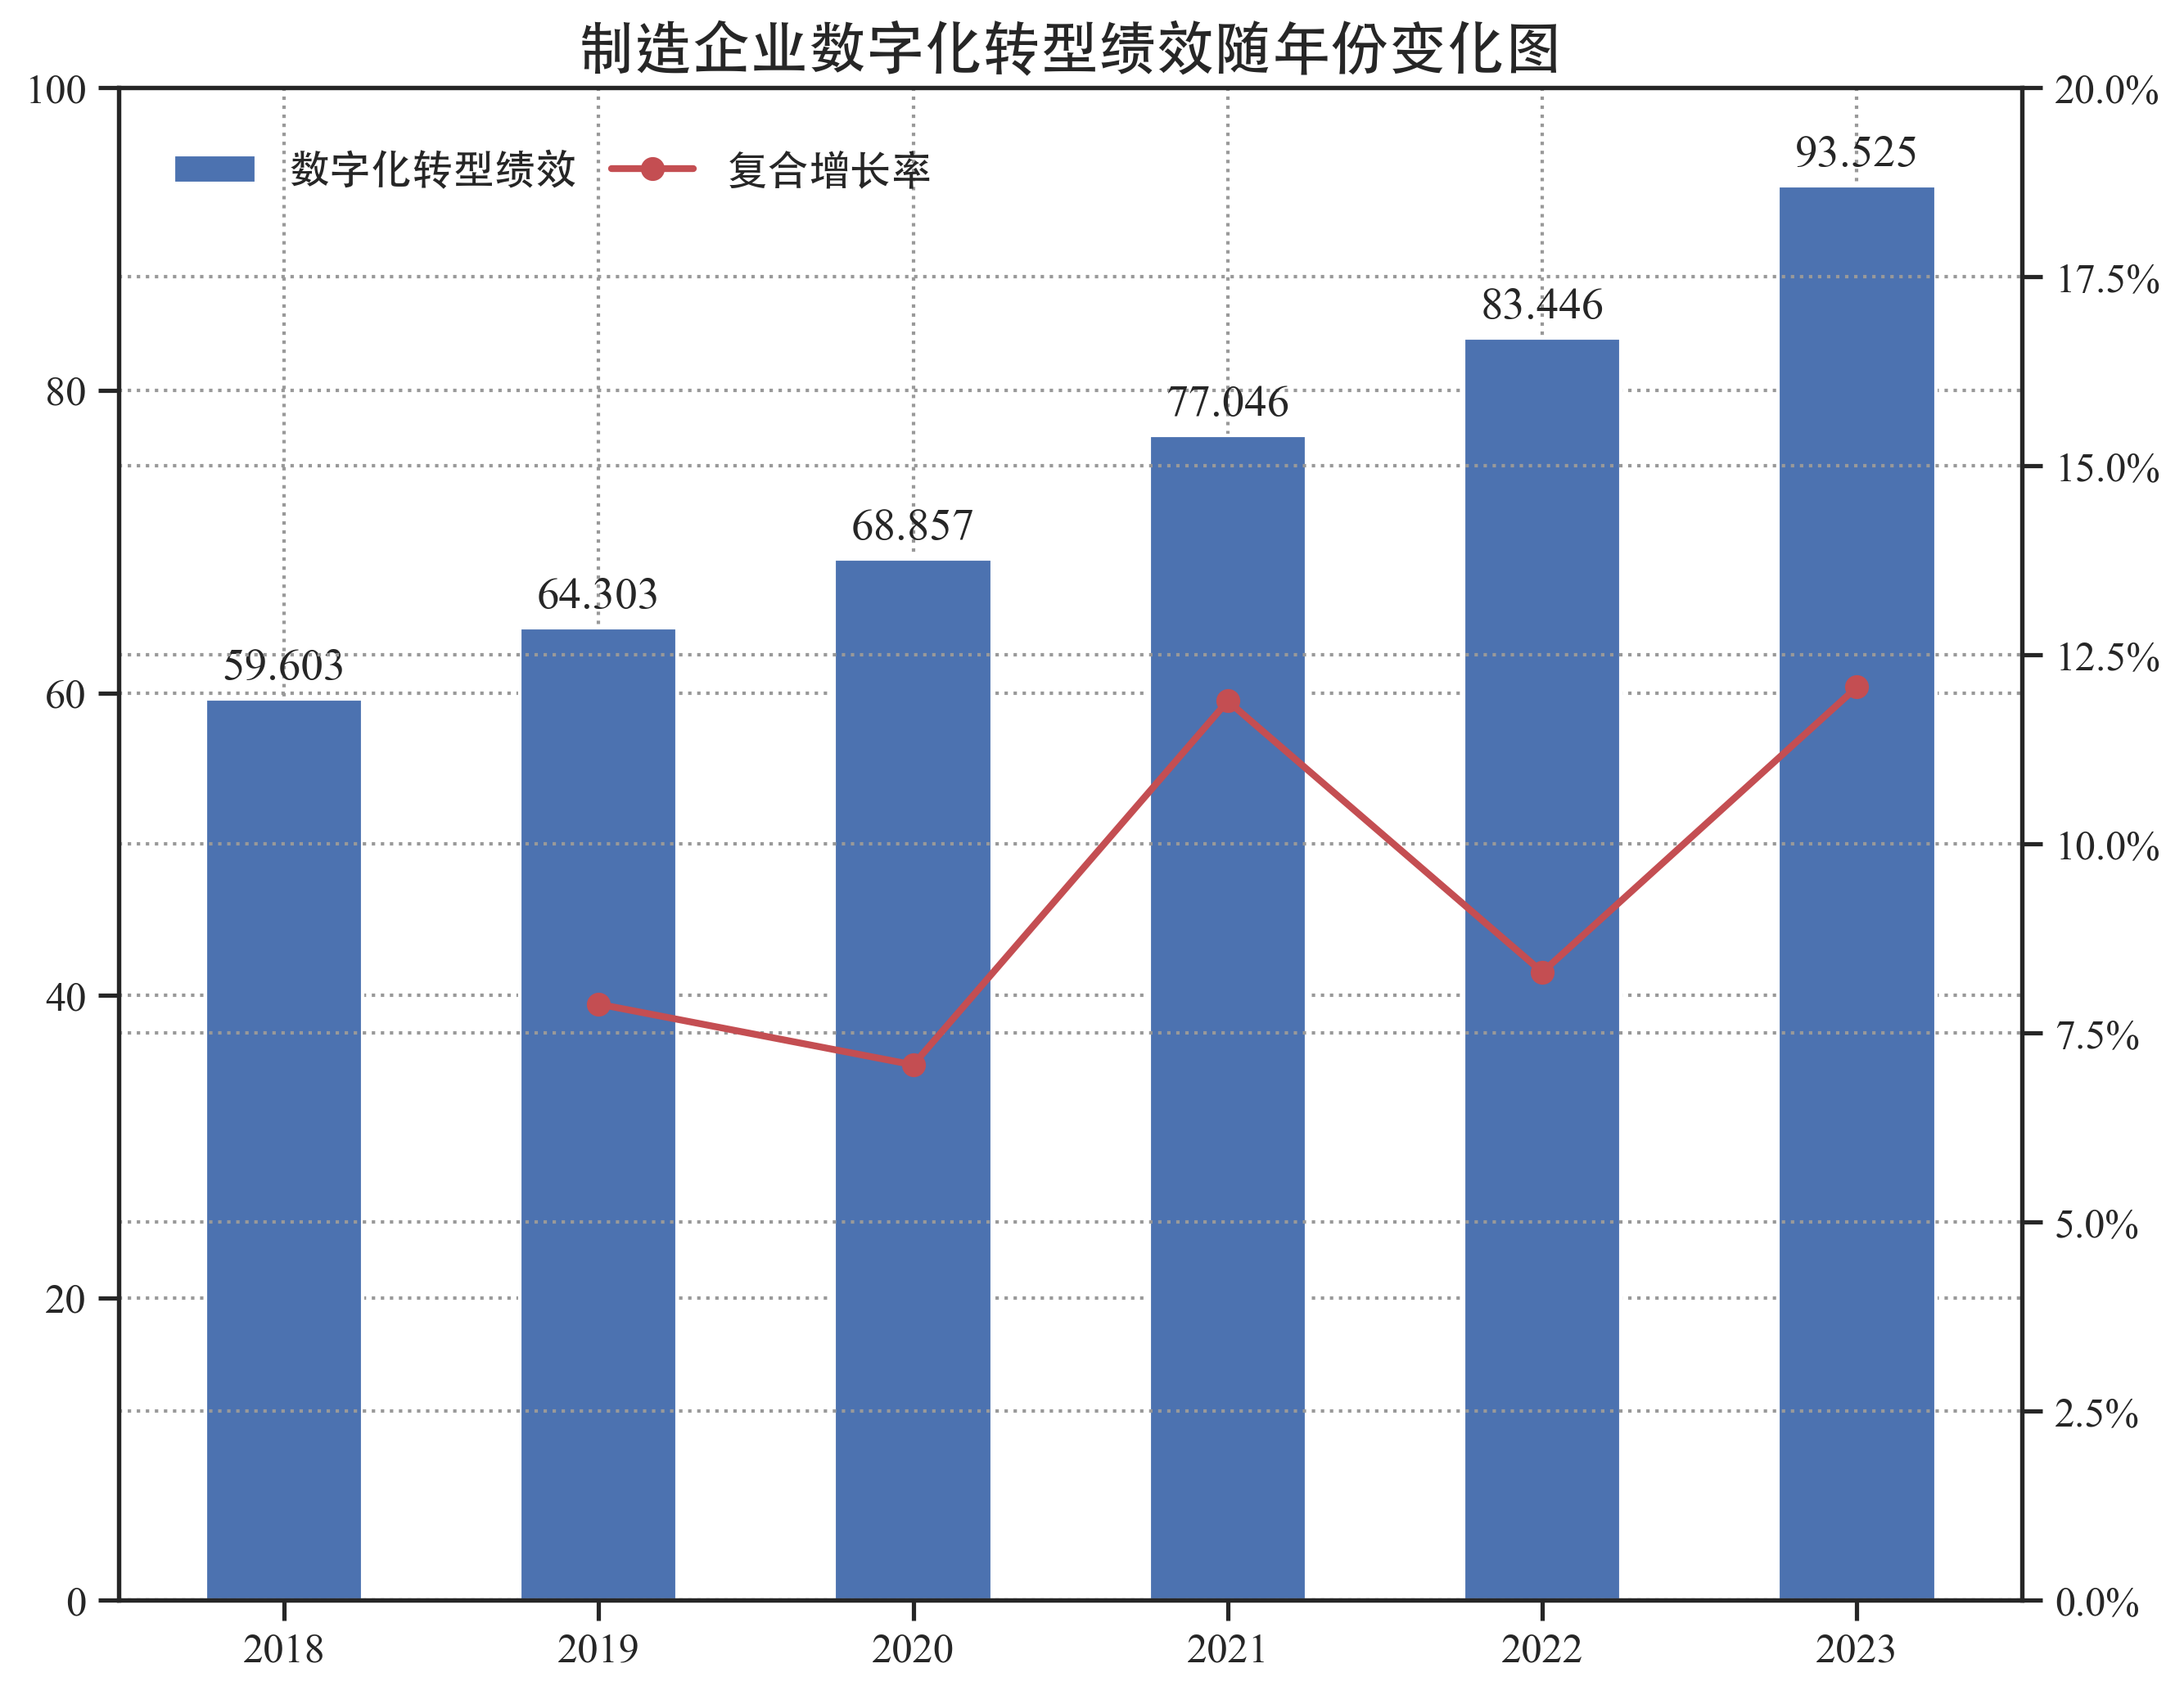

In [219]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context='notebook', style='ticks', font_scale=1.1)
sns.set_style("ticks", {'axes.grid':True, "grid.color": ".6", "grid.linestyle": ":"})
plt.rcParams['font.family'] = ['Times New Roman','Heiti TC', 'Heiti TC',] 
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

fig, ax = plt.subplots( figsize=(10, 8), dpi=300)
temp = totals[["截止日期", "预测值"]].groupby(["截止日期"]).sum()
temp["复合增长率"] = temp["预测值"] / temp["预测值"].shift(1)  -1
rects = ax.bar(temp.index, temp["预测值"], label="数字化转型绩效", width=0.5, color="b")
print(temp.to_dict())
ax.bar_label(rects, padding=3,fmt="%.3f")
ax.set_ylim([0, 100])
ax2 = ax.twinx()
ax2.plot(temp.index,temp["复合增长率"]*100,c="r",linewidth=2,marker='o',label="复合增长率")
ax2.set_ylim([0, 20])
ax2.set_yticklabels([f"{value}%" for value in ax2.get_yticks()], fontsize=12)
ax.legend(loc=(0.02, 0.92), ncols=1, frameon=False)
ax2.legend(loc=(0.25, 0.92), ncols=1, frameon=False)
plt.savefig('./assert/imgs/数字化转型绩效随年份变化图.svg', dpi=300, bbox_inches='tight', pad_inches=0.0,transparent=True)
ax.set_title('制造企业数字化转型绩效随年份变化图', fontsize=17)
plt.show()

{'预测值': {'民营': 278.0597497252914, '国企': 137.05762715433366, '其他': 16.35013095573493, '外资': 15.311760542084011}, '平均值': {'民营': 0.0491011389237668, '国企': 0.05946100961142458, '其他': 0.04837316850809151, '外资': 0.049392775942206486}}


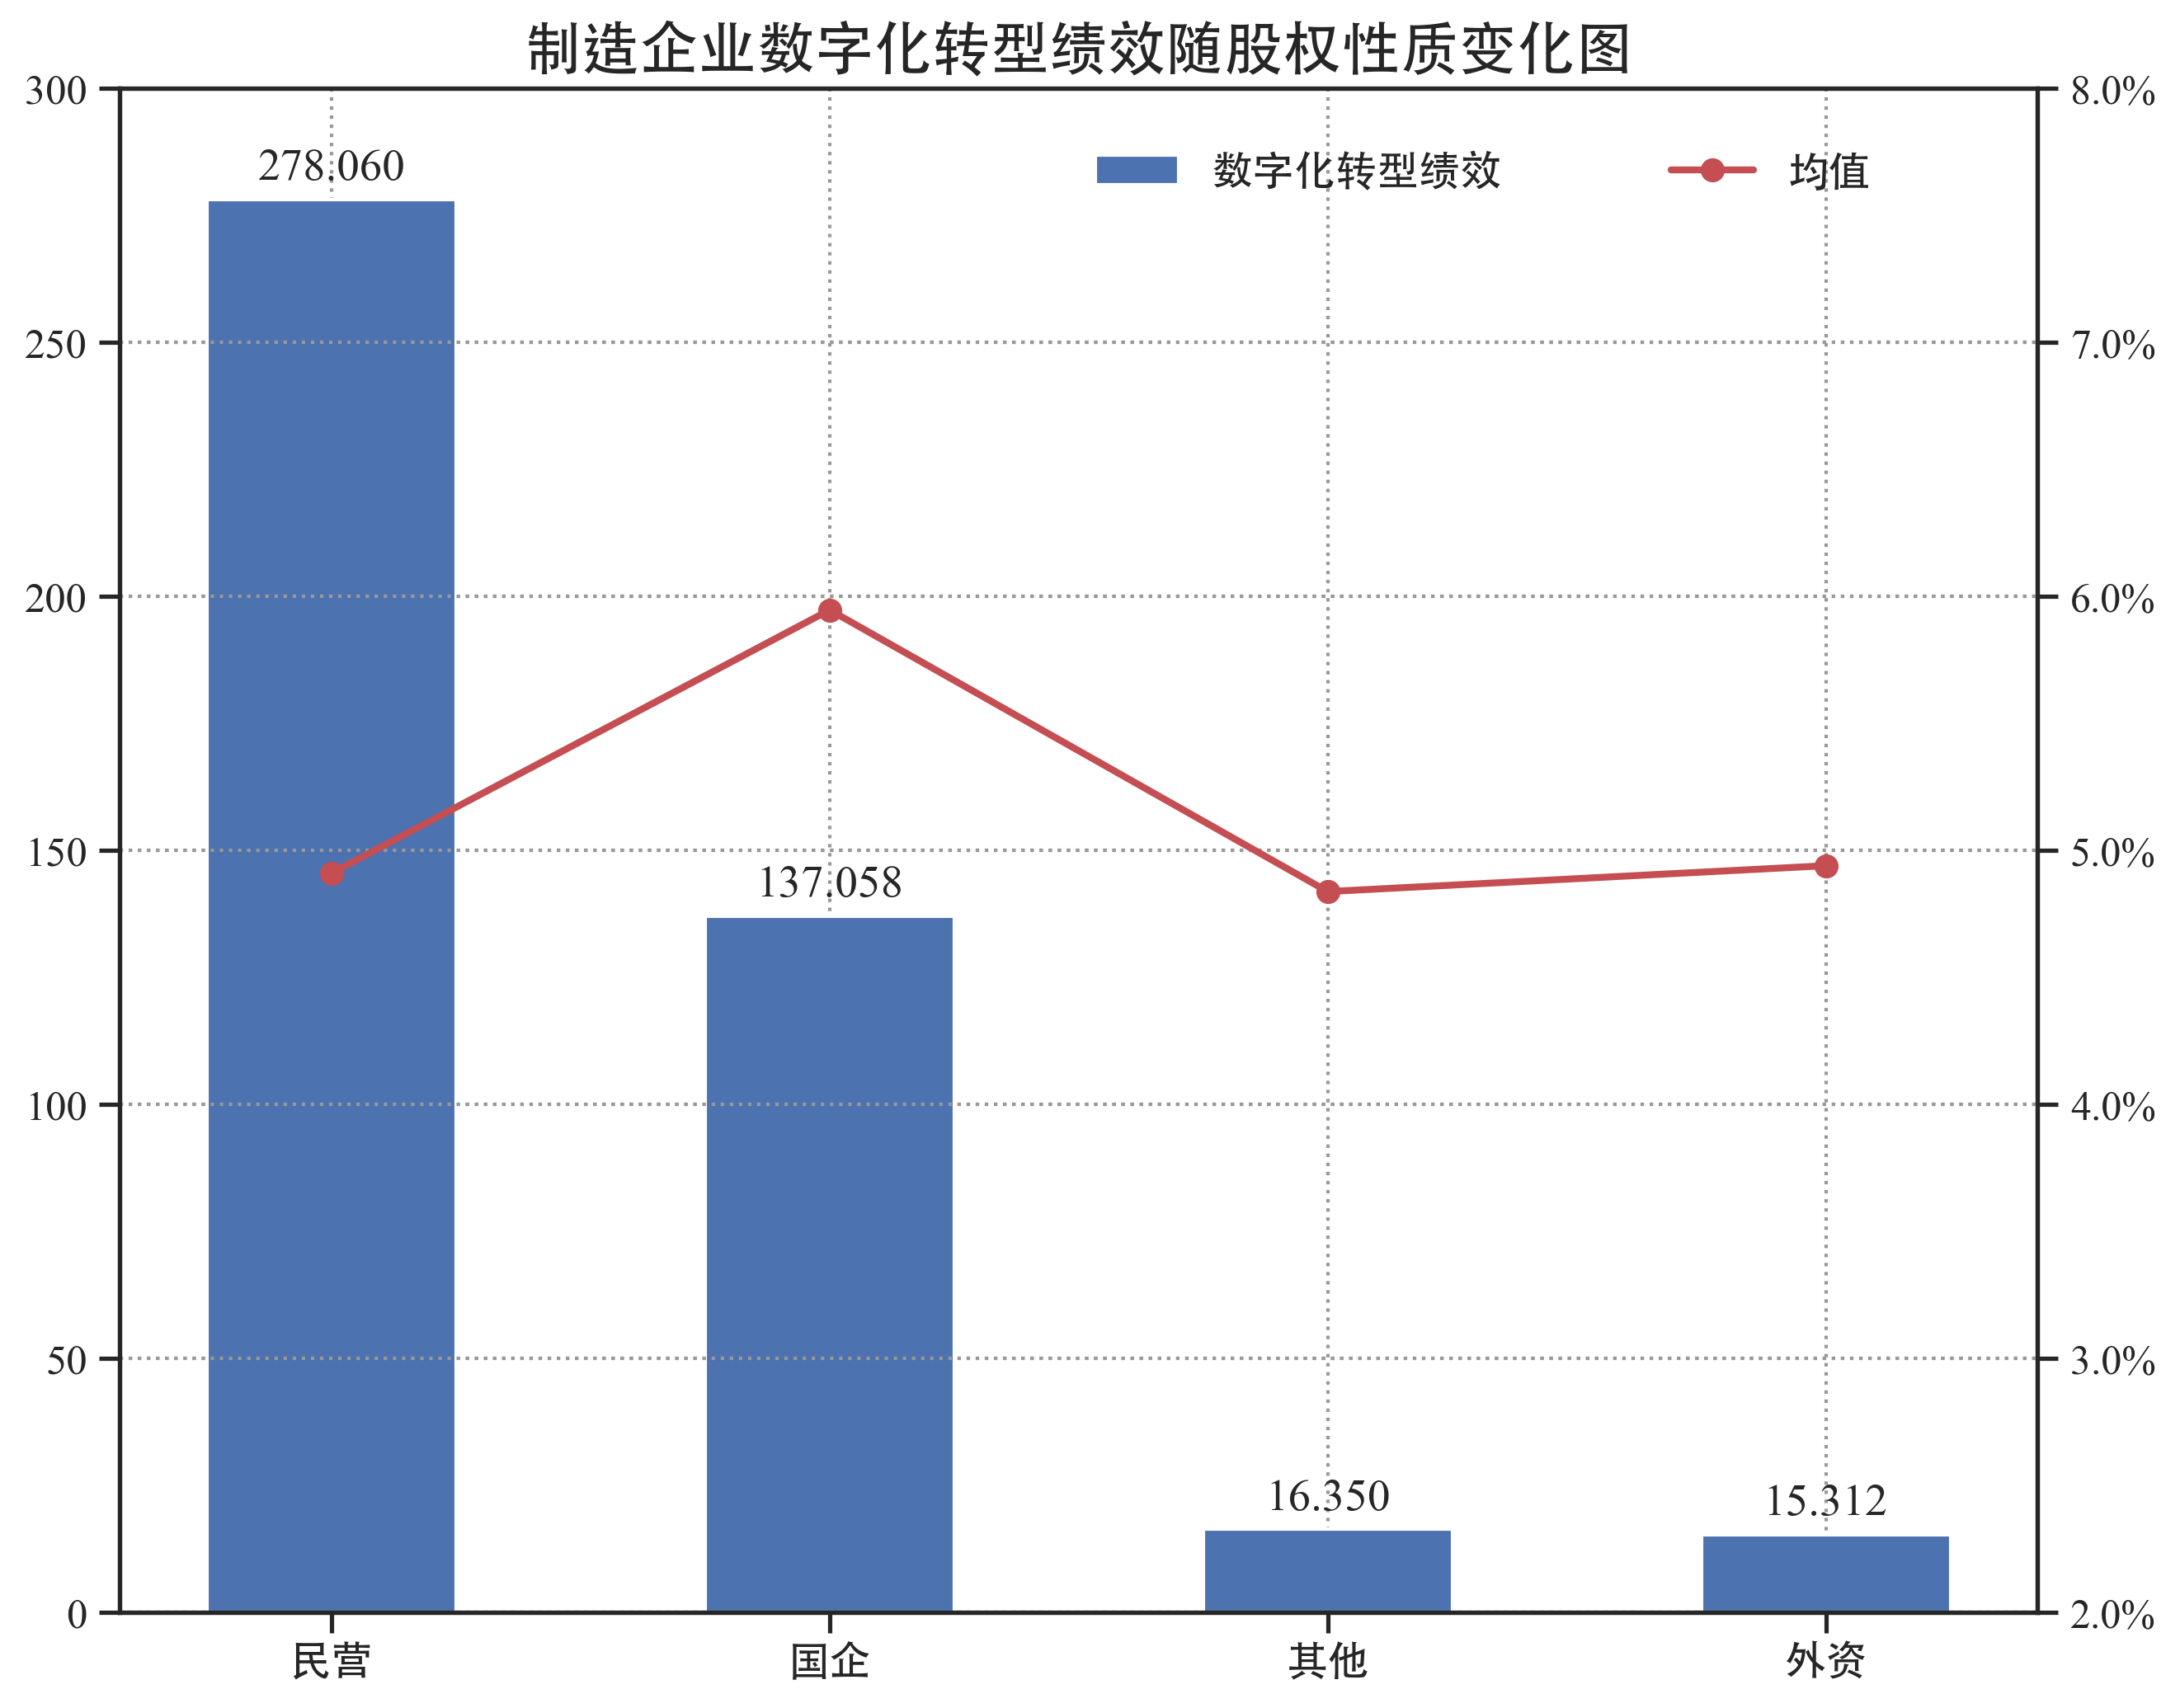

In [222]:
fig, ax = plt.subplots( figsize=(10, 8), dpi=300)
temp = totals[["股权性质", "预测值"]].groupby(["股权性质"]).sum()
temp["平均值"] = temp["预测值"]/totals[["股权性质", "预测值"]].groupby(["股权性质"]).count()["预测值"]
temp.sort_values("预测值", inplace=True, ascending=False)
rects = ax.bar(temp.index, temp["预测值"], label="数字化转型绩效", width=0.5, color="b")
ax.bar_label(rects, padding=3,fmt="%.3f")
print(temp.to_dict())
ax.set_ylim([0, 300])
ax2 = ax.twinx()
ax2.plot(temp.index,temp["平均值"]*100,c="r",linewidth=2,marker='o',label="均值")
ax2.set_ylim([2, 8])
ax2.set_yticklabels([f"{value}%" for value in ax2.get_yticks()], fontsize=12)
ax.legend(loc=(0.50, 0.92), ncols=1, frameon=False)
ax2.legend(loc=(0.80, 0.92), ncols=1, frameon=False)
plt.savefig('./assert/imgs/数字化转型绩效随股权性质变化图.svg', dpi=300, bbox_inches='tight', pad_inches=0.0,transparent=True)
ax.set_title('制造企业数字化转型绩效随股权性质变化图', fontsize=17)
plt.show()


{'预测值': {'金属制品、机械和设备修理业': 0.10707268085698834, '废弃资源综合利用业': 0.7858494016873911, '皮革、毛皮、羽毛及其制品和制鞋业': 1.5257791461465575, '木材加工和木、竹、藤、棕、草制品业': 1.620442753255967, '其他制造业': 2.259986678740475, '印刷和记录媒介复制业': 2.8058885922244516, '石油加工、炼焦和核燃料加工业': 3.3943030532203045, '文教、工美、体育和娱乐用品制造业': 3.999230293936034, '化学纤维制造业': 4.888754431906844, '家具制造业': 5.939317925885648, '造纸和纸制品业': 6.8115269078705145, '食品制造业': 7.709991530612995, '农副食品加工业': 8.054606323597993, '纺织服装、服饰业': 8.103116910684745, '纺织业': 8.395231467617307, '酒、饮料和精制茶制造业': 8.87605992656353, '黑色金属冶炼和压延加工业': 10.794181042793676, '仪器仪表制造业': 13.784050042060972, '铁路、船舶、航空航天和其他运输设备制造业': 13.894015906505674, '金属制品业': 15.016396743713624, '橡胶和塑料制品业': 15.811939834977265, '非金属矿物制品业': 16.59933855254606, '有色金属冶炼和压延加工业': 16.63986885659864, '通用设备制造业': 29.893284408638124, '汽车制造业': 35.201092044875004, '化学原料和化学制品制造业': 43.115330233868086, '医药制造业': 44.08848936114902, '专用设备制造业': 51.202811230187976, '电气机械和器材制造业': 65.46131209472215}, '平均值': {'金属制品、机械和设备修理业': 0.0535363404

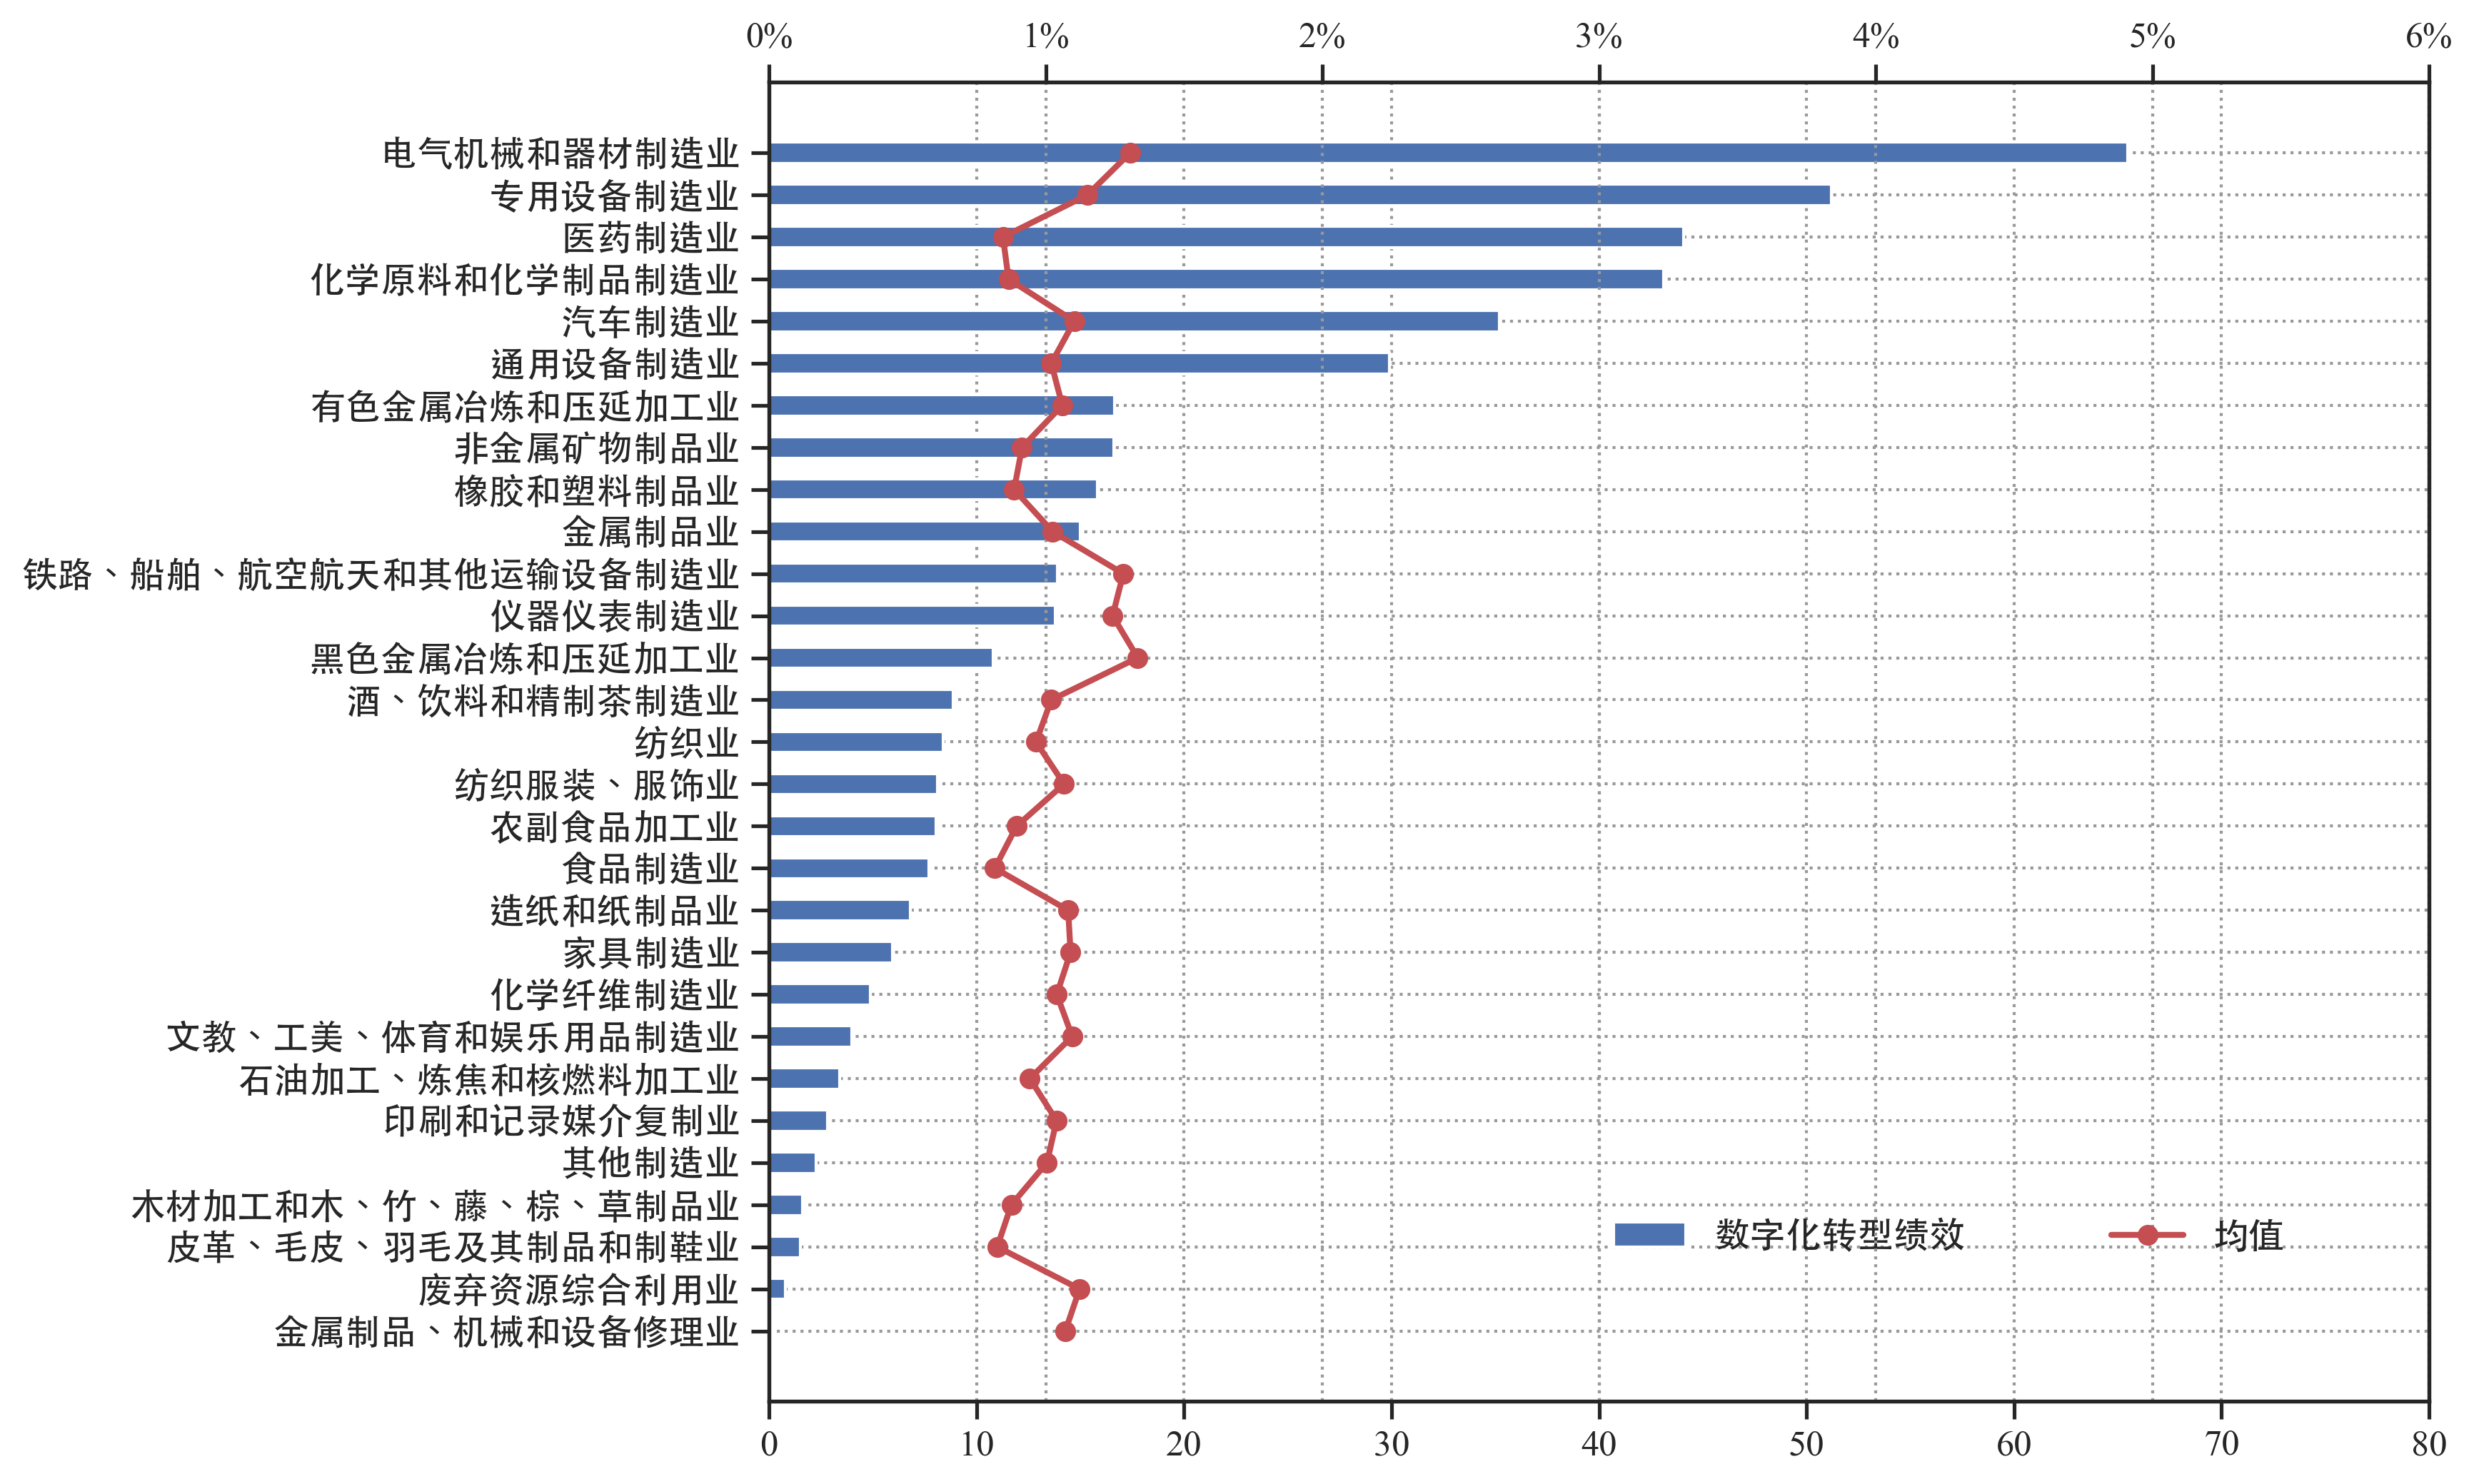

In [220]:

fig, ax = plt.subplots( figsize=(10, 8), dpi=300)

temp = totals[["行业名称", "预测值"]].groupby(["行业名称"]).sum()
temp["平均值"] = temp["预测值"]/totals[["行业名称", "预测值"]].groupby(["行业名称"]).count()["预测值"]
temp.sort_values("预测值", inplace=True, ascending=True)
ax.bar_label(rects, padding=3,fmt="%.3f")
ax.set_xlim([0, 80])
print(temp.to_dict())
rects = ax.barh(temp.index, width=temp["预测值"], label="数字化转型绩效", height=0.5, color="b")
ax2 = ax.twiny()
ax2.plot(temp["平均值"]*100, temp.index, c="r",linewidth=2,marker='o',label="均值")
ax2.set_xlim([0, 30])
ax2.set_xticklabels([f"{value}%" for value in ax2.get_yticks()], fontsize=12)
ax.legend(loc=(0.50, 0.1), ncols=1, frameon=False)
ax2.legend(loc=(0.80, 0.1), ncols=1, frameon=False)
plt.savefig('./assert/imgs/数字化转型绩效随二级行业变化图.svg', dpi=300, bbox_inches='tight', pad_inches=0.0,transparent=True)
plt.show()

{'所属省份': {0: '上海市', 1: '云南省', 2: '内蒙古自治区', 3: '北京市', 4: '吉林省', 5: '四川省', 6: '天津市', 7: '宁夏回族自治区', 8: '安徽省', 9: '山东省', 10: '山西省', 11: '广东省', 12: '广西壮族自治区', 13: '新疆维吾尔自治区', 14: '江苏省', 15: '江西省', 16: '河北省', 17: '河南省', 18: '浙江省', 19: '海南省', 20: '湖北省', 21: '湖南省', 22: '甘肃省', 23: '福建省', 24: '西藏自治区', 25: '贵州省', 26: '辽宁省', 27: '重庆市', 28: '陕西省', 29: '青海省', 30: '黑龙江省'}, '预测值': {0: 67.88429580898061, 1: 5.025270387344312, 2: 4.434091835954156, 3: 41.032579461059946, 4: 4.391555677381396, 5: 19.720897889221373, 6: 12.108050874469757, 7: 1.4779352102081347, 8: 31.888407075896303, 9: 73.35600179361246, 10: 5.111370291422358, 11: 184.71709562311057, 12: 3.79977605606267, 13: 5.021557872840535, 14: 175.219048360492, 15: 10.120121055002784, 16: 15.425482769091815, 17: 22.241403291740443, 18: 207.6729607070847, 19: 2.315857522556547, 20: 12.462079586537206, 21: 18.14123632095233, 22: 3.001276947928729, 23: 22.439813535342303, 24: 1.5185753094737462, 25: 4.166025951223528, 26: 16.09640193699419, 27: 12.943

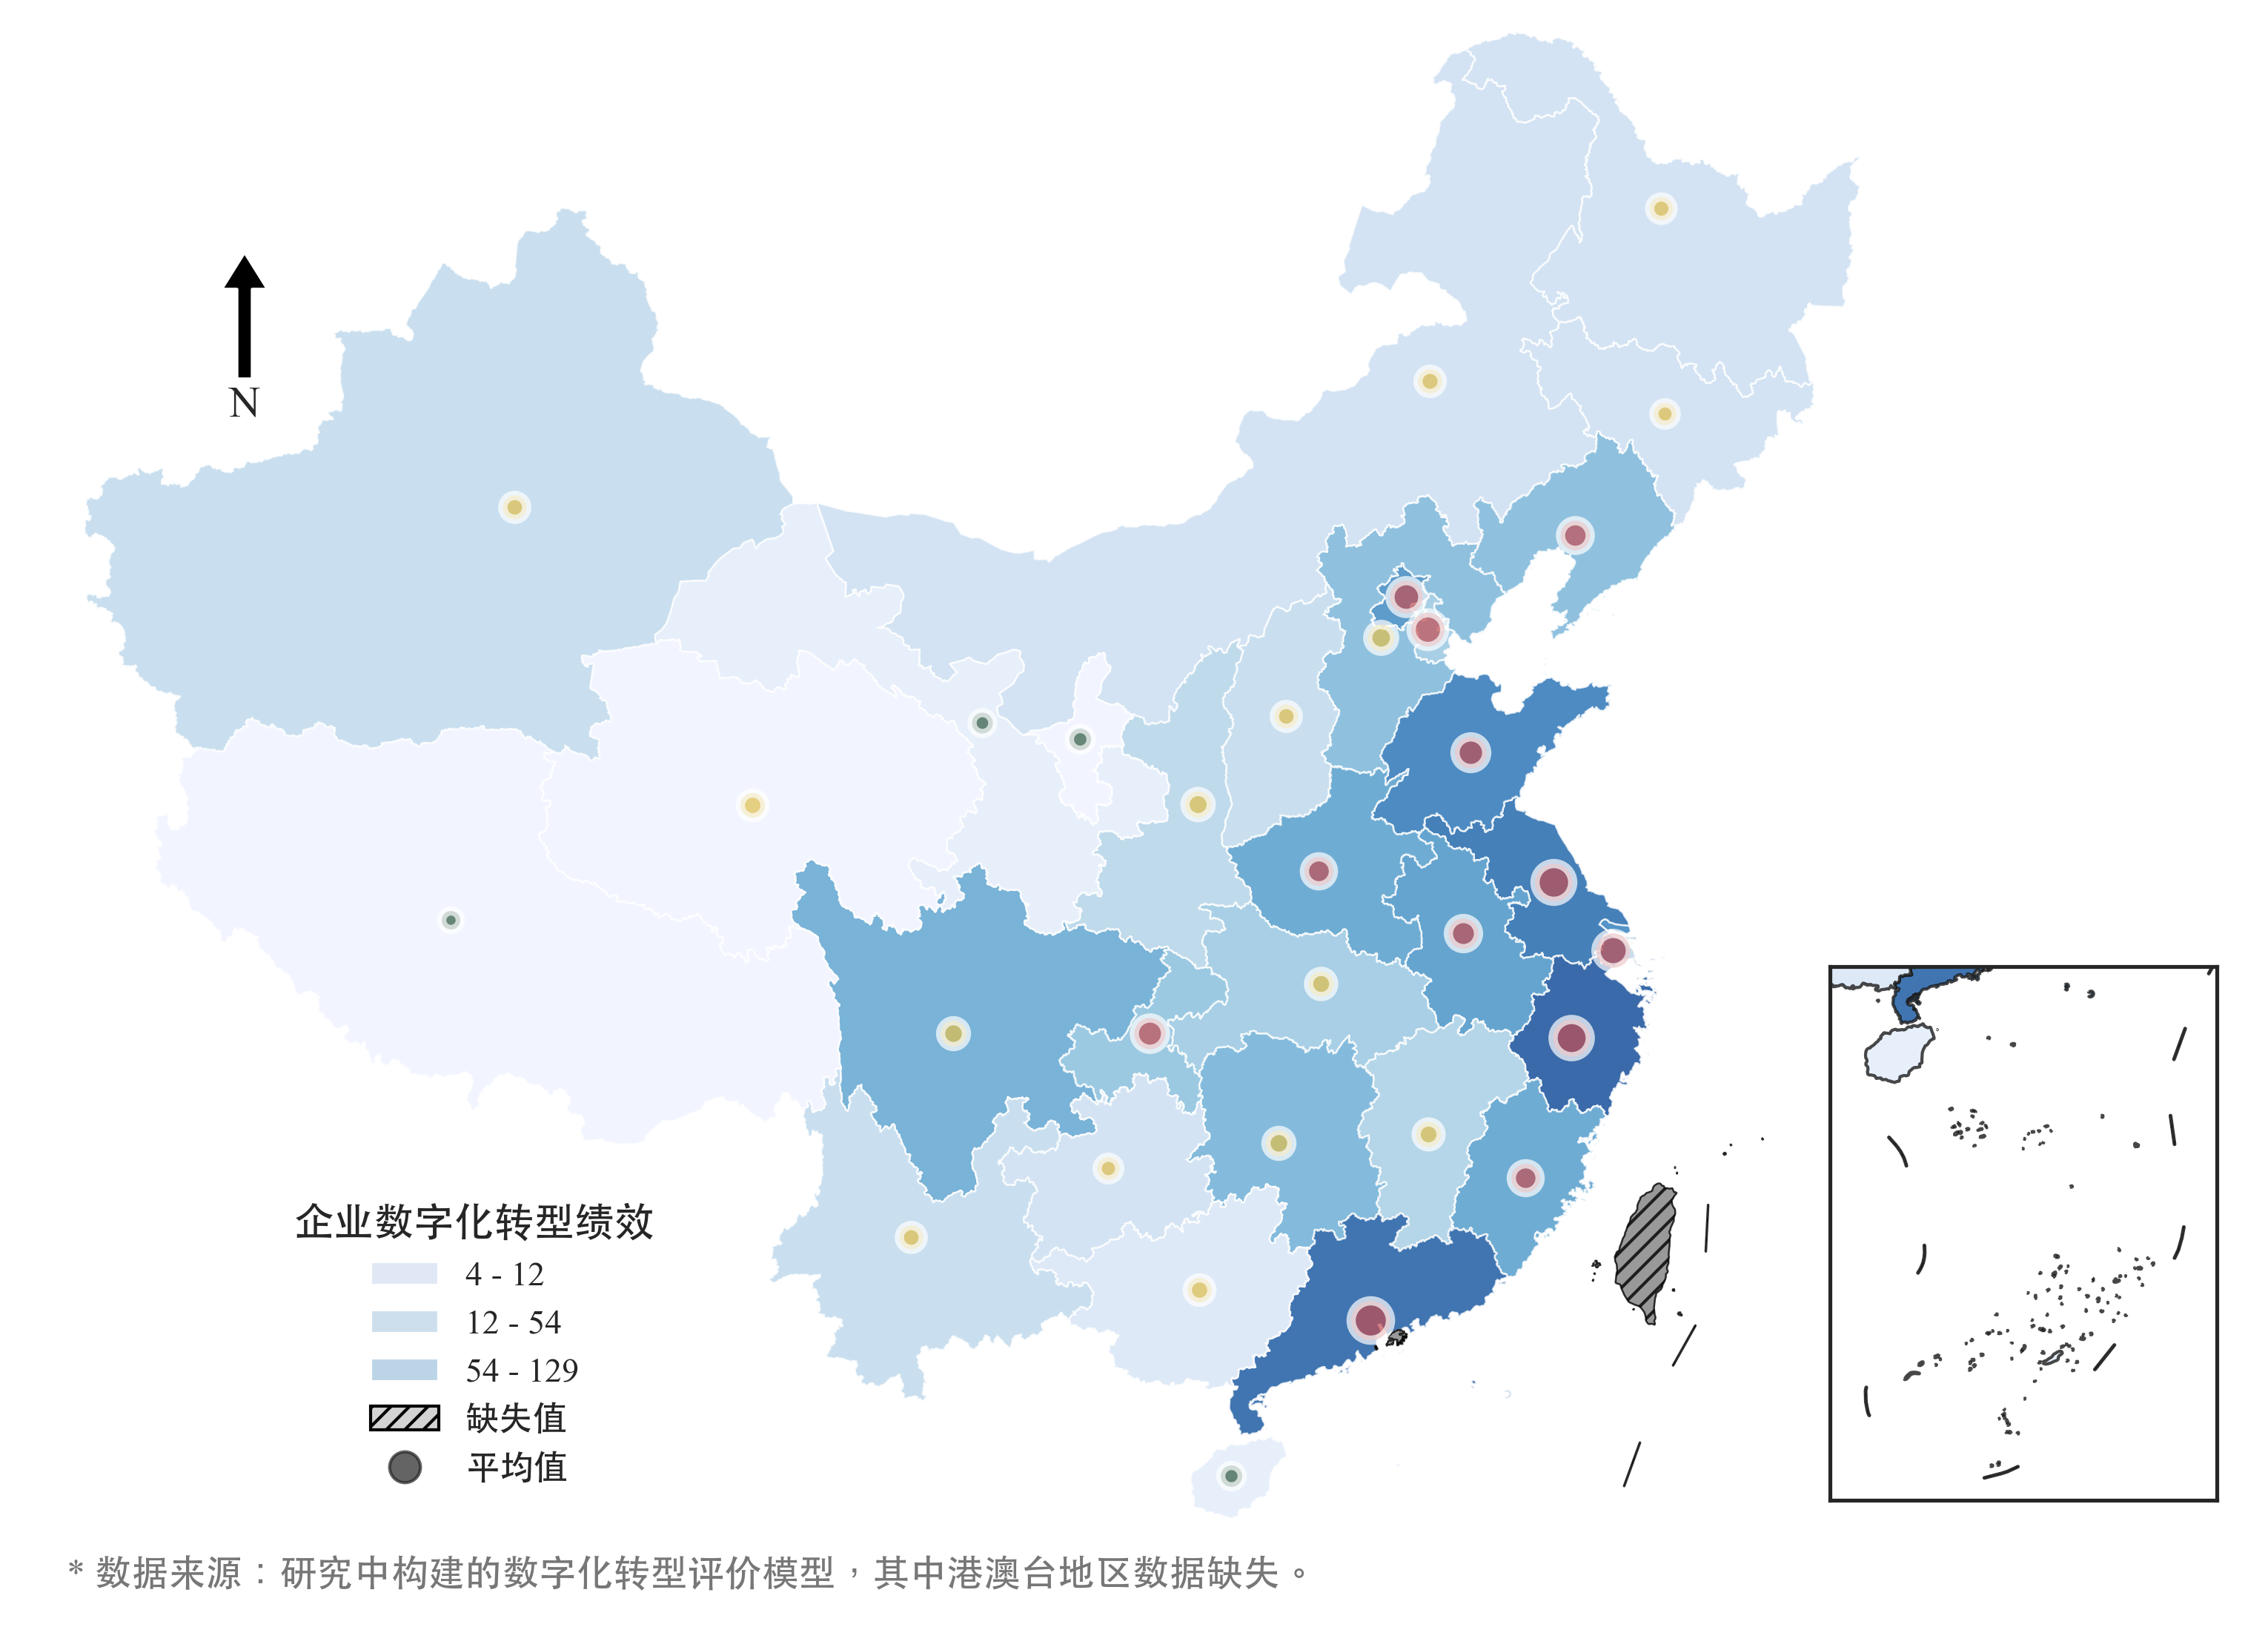

In [221]:

# 游客评分空间分布
from matplotlib import cm
import pandas as pd
import mapclassify as mc
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.patches as mpatches
from palettable.colorbrewer import sequential
from matplotlib import colors

# cm.get_cmap()
# cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', ['#CCC','#B49775', '#651717'])
cmap = sequential.Blues_7.mpl_colormap
temp = totals[["所属省份", "预测值"]].groupby(["所属省份"]).sum()
temp["企业数"] = totals[["所属省份", "预测值"]].groupby(["所属省份"]).count()["预测值"]
# 微调
temp.reset_index(inplace=True)
def adjust(x):
    if x["企业数"]>1000:
        return x["预测值"]*3
    elif 500<x["企业数"]<=1000:
        return x["预测值"]*2.2
    elif 300<x["企业数"]<=500:
        return x["预测值"]*1.8
    elif 200<x["企业数"]<=300:
        return x["预测值"]*1.5
    elif 100<x["企业数"]<=200:
        return x["预测值"]*1.2
    elif 50<x["企业数"]<=100:
        return x["预测值"]*1.1
    else:
        return x["预测值"]
temp["预测值"] = temp.apply(lambda x: adjust(x),axis=1)
temp["预测值"] = temp.apply(lambda x: x["预测值"]+5 if x["所属省份"] in ["江苏省","重庆市","辽宁省","天津市"] else x["预测值"],axis=1)
temp["平均值"] = temp["预测值"]/ temp["企业数"]
print(temp.to_dict())
china = gpd.read_file('./data/china/china.shp', encoding='utf-8')
albers_proj = '+proj=aea +lat_1=25 +lat_2=47 +lon_0=105'
data_with_geometry = pd.merge(left=temp,right=china,left_on='所属省份',right_on='name',how='right')
data_with_geometry.drop(['所属省份','adcode', 'childrenNu', 'subFeature'],axis=1,inplace=True)
data_with_geometry = gpd.GeoDataFrame(data_with_geometry, crs='EPSG:4326')

bound = gpd.GeoDataFrame({ 'x': [80, 150, 107, 121.5], 'y': [14, 48, 2.8, 21]})
# 添加矢量列
bound.geometry = bound.apply(lambda row: Point([row['x'], row['y']]), axis=1)
# 初始化CRS
bound.crs = 'EPSG:4326'
# 再投影
bound.to_crs(albers_proj, inplace=True)
# 初始化图床
fig = plt.figure(figsize=(10, 8),dpi=300)
# 创建覆盖整个画布的子图1
ax = fig.add_axes((0, 0, 1, 1))
ax.set_xlim(bound.geometry[0].x, bound.geometry[1].x)
ax.set_ylim(bound.geometry[0].y, bound.geometry[1].y)
# 创建南海插图对应的子图，这里的位置和大小信息是我调好的，(left, bottom, width, height)
ax_child = fig.add_axes([0.80, 0.1, 0.2, 0.3])
data_with_geometry['point'] = data_with_geometry.representative_point()
data_with_geometry.set_geometry('geometry', inplace=True)
k=20
missing_kwds = {"color": "grey", "edgecolor": "black","label": "缺失值","hatch": "////"}
ax = data_with_geometry.to_crs(albers_proj).plot(ax=ax, column='预测值', cmap=cmap, edgecolor='white', linewidth=0.6, scheme='NaturalBreaks', k=k, missing_kwds=missing_kwds, alpha=0.8,)
# whiteedgecolor='black',linewidth=1
ax_child = data_with_geometry.to_crs(albers_proj).plot(ax=ax_child, column='预测值', cmap=cmap, edgecolor='k', linewidth=1, scheme='NaturalBreaks', k=k, missing_kwds=missing_kwds, alpha=0.8)
# data_with_geometry['geometry'] = data_with_geometry['geometry'].buffer(0)
# data_with_geometry.boundary.plot(ax=ax, color='black', linewidth=5)
# merged_gdf = data_with_geometry.dissolve(by='name')
# merged_gdf['point'] = merged_gdf.representative_point()
# merged_gdf.set_geometry('geometry', inplace=True)
# merged_gdf.to_crs(albers_proj).boundary.plot(ax=ax, color='black', linewidth=1.5)
ax_child.set_xlim(bound.geometry[2].x, bound.geometry[3].x)
ax_child.set_ylim(bound.geometry[2].y, bound.geometry[3].y)
# 移除子图坐标轴刻度，因为这里的子图需要有边框，所以只移除坐标轴刻度
ax_child.set_xticks([])
ax_child.set_yticks([])
# 根据转换过投影的代表点，循环添加文字至地图上对应位置
data_with_geometry['平均值'].fillna(0,inplace=True)
for idx, _ in enumerate(data_with_geometry.representative_point().to_crs(albers_proj)):
    size =list(data_with_geometry['平均值'])[idx]
    if size<=0.05:
        color ="#2B573F"
    elif 0.05<size<=0.08:
        color ="#E0BF4B"
    else:
        color="r"
    ax.scatter(_.x, _.y, s=1000*size,c=color, alpha=0.7,edgecolor='white', linewidths=3)  #   size*

# 设置图例标题，位置，排列方式，是否带有阴影
bp = mc.BoxPlot(data_with_geometry['预测值'])
bins = bp.bins
color_name=['#4569A4','#73A2CB','#BCD5E6','#CDDFED','#E0E8F6']
LegendElement =[mpatches.Patch(facecolor=color_name[4-i], label=f'{int(max(bins[i+1], 0))} - {int(bins[i+2])}' ) for i in range(len(bins)-2)] + [mpatches.Patch(facecolor='lightgrey', edgecolor='black', hatch='////', label='缺失值')]+ \
               [plt.plot([], [], marker='.', ms=20, ls='', mec=None, color='#222', alpha=0.7, label='平均值')[0]]
# 将制作好的图例映射对象列表导入legend()中，并配置相关参数
ax.legend( handles = LegendElement, fontsize=11, borderpad=0.5, fancybox=True, framealpha=0.7, ncol=1, title='企业数字化转型绩效', title_fontsize=13, frameon=False, bbox_to_anchor=(0.3, 0.25))
ax.axis('off') # 移除坐标轴
ax.annotate('N', xy=(0.1, 0.85), xytext=(0.1, 0.85 - 0.1),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=14,
                xycoords=ax.transAxes)
plt.tight_layout(pad=1.5) # 调整不同标题之间间距
ax.annotate('* 数据来源：研究中构建的数字化转型评价模型，其中港澳台地区数据缺失。', xy=(0.03, 0.05), xycoords='figure fraction',  horizontalalignment='left',verticalalignment='top', fontsize=12, color='#777')
plt.savefig(f'./assert/imgs/地区数字化转型程度差异.svg', dpi=300, bbox_inches='tight', pad_inches=0.0,transparent=True)
plt.show()